In [ ]:
import pandas as pd
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.utils import class_weight
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"fizarazvi10","key":"8b8b01fb838f83650c5dc57ed3c48e9d"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download elemento/nyc-yellow-taxi-trip-data/data -f yellow_tripdata_2015-01.csv

yellow_tripdata_2015-01.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('yellow_tripdata_2015-01.csv.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
# df = pd.read_csv("C:/Users/vishy/OneDrive/Desktop/CONCORDIA/SOEN 471/Personal_Project/yellow_tripdata_2015-01.csv")
# df=pd.read_csv("/content/drive/MyDrive/NYC data/yellow_tripdata_2015-01.csv")
df=pd.read_csv("/content/yellow_tripdata_2015-01.csv")

In [ ]:
df = df[:1500000]

In [ ]:
df = df[(df['trip_distance'] > 0.1) & (df['trip_distance'] < 399)]

In [ ]:
df=df[(df['pickup_latitude'] > 40.492083) & (df['pickup_latitude']<40.944536) &
     (df['pickup_longitude']> -74.267880)& (df['pickup_longitude']< -73.662022)]

In [ ]:
#drop unnecessary column
df = df.drop(['VendorID','RateCodeID', 'extra','dropoff_longitude', 'dropoff_latitude',
              'store_and_fwd_flag','payment_type','improvement_surcharge','mta_tax',
             'tip_amount','tolls_amount','total_amount','tpep_dropoff_datetime'], axis=1)
print(df.count)
df.head()

<bound method DataFrame.count of         tpep_pickup_datetime  passenger_count  trip_distance  \
0        2015-01-15 19:05:39                1           1.59   
1        2015-01-10 20:33:38                1           3.30   
2        2015-01-10 20:33:38                1           1.80   
3        2015-01-10 20:33:39                1           0.50   
4        2015-01-10 20:33:39                1           3.00   
...                      ...              ...            ...   
1499994  2015-01-19 17:38:45                1           1.30   
1499995  2015-01-19 17:38:45                2           1.74   
1499996  2015-01-19 17:38:45                2           1.42   
1499997  2015-01-19 17:38:46                1           1.36   
1499999  2015-01-31 10:42:31                2           0.57   

         pickup_longitude  pickup_latitude  fare_amount  
0              -73.993896        40.750111         12.0  
1              -74.001648        40.724243         14.5  
2              -73.96334

,tpep_pickup_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,fare_amount
0,2015-01-15 19:05:39,1,1.59,-73.993896,40.750111,12.0
1,2015-01-10 20:33:38,1,3.30,-74.001648,40.724243,14.5
2,2015-01-10 20:33:38,1,1.80,-73.963341,40.802788,9.5
3,2015-01-10 20:33:39,1,0.50,-74.009087,40.713818,3.5
4,2015-01-10 20:33:39,1,3.00,-73.971176,40.762428,15.0


In [ ]:
df = df[df['passenger_count'] != 0]

In [ ]:
#new column weekday
timestamp = pd.to_datetime(pd.Series(df['tpep_pickup_datetime']))
df['weekday'] = timestamp.dt.day_name()
df.head()

,tpep_pickup_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,fare_amount,weekday
0,2015-01-15 19:05:39,1,1.59,-73.993896,40.750111,12.0,Thursday
1,2015-01-10 20:33:38,1,3.30,-74.001648,40.724243,14.5,Saturday
2,2015-01-10 20:33:38,1,1.80,-73.963341,40.802788,9.5,Saturday
3,2015-01-10 20:33:39,1,0.50,-74.009087,40.713818,3.5,Saturday
4,2015-01-10 20:33:39,1,3.00,-73.971176,40.762428,15.0,Saturday


In [ ]:
features = df[['fare_amount', 'trip_distance']]
df.head()

,tpep_pickup_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,fare_amount,weekday
0,2015-01-15 19:05:39,1,1.59,-73.993896,40.750111,12.0,Thursday
1,2015-01-10 20:33:38,1,3.30,-74.001648,40.724243,14.5,Saturday
2,2015-01-10 20:33:38,1,1.80,-73.963341,40.802788,9.5,Saturday
3,2015-01-10 20:33:39,1,0.50,-74.009087,40.713818,3.5,Saturday
4,2015-01-10 20:33:39,1,3.00,-73.971176,40.762428,15.0,Saturday


In [ ]:
# Select the features you want to scale
features_to_scale = ['fare_amount', 'trip_distance']

# Initialize StandardScaler
scaler = StandardScaler()

# Scale the selected features and replace the original values in the DataFrame
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

In [ ]:
df.head()

,tpep_pickup_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,fare_amount,weekday
0,2015-01-15 19:05:39,1,-0.353865,-73.993896,40.750111,0.017493,Thursday
1,2015-01-10 20:33:38,1,0.149413,-74.001648,40.724243,0.276637,Saturday
2,2015-01-10 20:33:38,1,-0.292059,-73.963341,40.802788,-0.241651,Saturday
3,2015-01-10 20:33:39,1,-0.674668,-74.009087,40.713818,-0.863597,Saturday
4,2015-01-10 20:33:39,1,0.061119,-73.971176,40.762428,0.328466,Saturday


# **Methods**

In [ ]:
def elbow_method(df):
  inertia = []
  for k in range(1, 11):
      kmeans = KMeans(n_clusters=k, random_state=42)
      kmeans.fit(features)
      inertia.append(kmeans.inertia_)
  plt.plot(range(1, 11), inertia, marker='o')
  plt.title('Elbow Method')
  plt.xlabel('Number of clusters')
  plt.ylabel('Inertia')
  plt.show()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_lat_long_fare(df_clustered):
  latitude = df_clustered['pickup_latitude']
  longitude = df_clustered['pickup_longitude']
  fare_amount = df_clustered['fare_amount']

  # Create a 3D scatter plot
  fig = plt.figure(figsize=(10, 8))
  ax = fig.add_subplot(111, projection='3d')

  # Plot data points
  ax.scatter(latitude, longitude, fare_amount, c='blue', marker='o', alpha=0.5)

  # Set labels and title
  ax.set_xlabel('Latitude')
  ax.set_ylabel('Longitude')
  ax.set_zlabel('Fare Amount')
  ax.set_title('3D Scatter Plot of Latitude, Longitude, and Fare Amount')

  plt.show()

In [ ]:
def applyKMeans(df):
  k = 3 # Example based on the Elbow plot; adjust based on your own data
  features = df[['fare_amount', 'trip_distance']]
  kmeans = KMeans(n_clusters=k, random_state=42)
  df['cluster_label'] = kmeans.fit_predict(features)
  #evaluateKMeans(df)
  return df

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def evaluateKMeans(df):
    features = df[['fare_amount', 'trip_distance']]
    cluster_labels = df['cluster_label']

    # Calculate silhouette score
    silhouette_avg = silhouette_score(features, cluster_labels)

    # Calculate Davies-Bouldin index
    db_index = davies_bouldin_score(features, cluster_labels)

    # Calculate Calinski-Harabasz index
    ch_index = calinski_harabasz_score(features, cluster_labels)

    print("Silhouette Score:", silhouette_avg)
    print("Davies-Bouldin Index:", db_index)
    print("Calinski-Harabasz Index:", ch_index)

In [ ]:
def find_optimal_cluster(df):
    # Compute the mean fare amount for each cluster
    cluster_means = df.groupby('cluster_label')['fare_amount'].mean()
    cluster_means_distance = df.groupby('cluster_label')['trip_distance'].mean()
    print(cluster_means)
    print(cluster_means_distance)

    # Find the cluster with the highest mean fare amount
    optimal_cluster = cluster_means.idxmax()

    # Assign new label 'optimal' to each data point
    df['optimal'] = 0  # Initialize 'optimal' column with zeros
    df.loc[df['cluster_label'] == optimal_cluster, 'optimal'] = 1  # Assign 1 to data points in optimal cluster

    return df

In [ ]:
def plot_cluster_fare(df):
    plt.figure(figsize=(10, 6))
    plt.scatter(df['cluster_label'], df['fare_amount'], c=df['cluster_label'], cmap='viridis', s=10)
    plt.xlabel('Cluster')
    plt.ylabel('Fare Amount')
    plt.title('Fare Amounts for Each Cluster')
    plt.colorbar(label='Cluster')
    plt.show()

In [ ]:
def display_results(predictions, y_test):
  accuracy = accuracy_score(y_test, predictions)
  precision = precision_score(y_test, predictions)
  recall = recall_score(y_test, predictions)
  f1 = f1_score(y_test, predictions)
  print("Accuracy", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1 Score:", f1)

In [ ]:
def train_for_day(df):
  # Apply k means
  df_clustered = applyKMeans(df)
  evaluateKMeans(df_clustered)

  cluster_counts = df_clustered['cluster_label'].value_counts()
  print(cluster_counts)

  # Plot cluster vs fare
  plot_cluster_fare(df_clustered)

  # Get optimal cluster
  df_clustered = find_optimal_cluster(df_clustered)

  # Classify for the optimal cluster
  X = df_clustered[['pickup_latitude', 'pickup_longitude']]  # Add additional relevant features as needed
  y = df_clustered['optimal']  # Your binary labels
  ros = RandomOverSampler(random_state=42)

  # Resample the dataset
  X_ros, y_ros = ros.fit_resample(X, y)
  X = X_ros#df_monday_clustered[['pickup_latitude', 'pickup_longitude']]  # Add additional relevant features as needed
  y = y_ros
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
  classes_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)


  # Algo 1:
  rfc = RandomForestClassifier(n_estimators=100, random_state=42)
  rfc.fit(X_train, y_train)#, sample_weight=classes_weights)
  predictions = rfc.predict(X_test)

  # Evaluation
  display_results(predictions, y_test)

  # Algo 2:

  xgb_classifier = xgb.XGBClassifier(n_estimators=100)#scale_pos_weight=sum(y_train == 0) / sum(y_train == 1))
  xgb_classifier.fit(X_train, y_train)#, sample_weight=classes_weights)
  predictions = xgb_classifier.predict(X_test)

  # Evalautions
  display_results(predictions, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-49-d07ee53a75ad>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster_label'] = kmeans.fit_predict(features)


Silhouette Score: 0.7185139342587131
Davies-Bouldin Index: 0.4889803332090146
Calinski-Harabasz Index: 365902.6327346815
cluster_label
0    119972
2     18391
1      5390
Name: count, dtype: int64


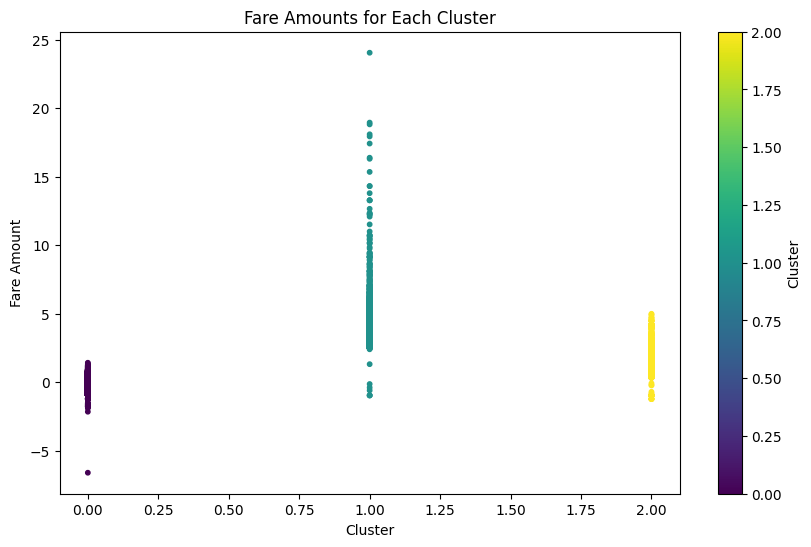

cluster_label
0   -0.358983
1    4.106471
2    1.286873
Name: fare_amount, dtype: float64
cluster_label
0   -0.344454
1    4.290865
2    1.287683
Name: trip_distance, dtype: float64


<ipython-input-51-ee7db6354276>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['optimal'] = 0  # Initialize 'optimal' column with zeros


Accuracy 0.9920788644445087
Precision: 0.9845062059996041
Recall: 1.0
F1 Score: 0.9921926200313435
Accuracy 0.8319505073574051
Precision: 0.9020906285753909
Recall: 0.7472215042646678
F1 Score: 0.8173850213621513


In [ ]:
df_monday = df[df['weekday'] == 'Monday']
train_for_day(df_monday)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

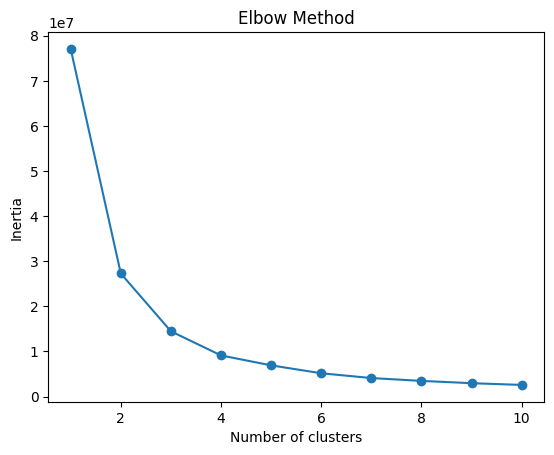

In [ ]:
elbow_method(df_monday)

167464


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-49-d07ee53a75ad>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster_label'] = kmeans.fit_predict(features)


Silhouette Score: 0.6891729340864609
Davies-Bouldin Index: 0.5359616098271593
Calinski-Harabasz Index: 350052.6436173753
cluster_label
0    138520
2     23402
1      5542
Name: count, dtype: int64


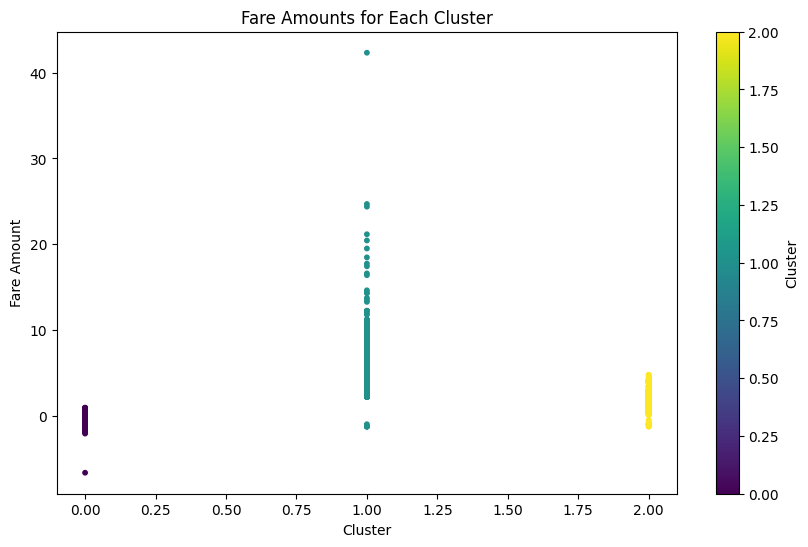

cluster_label
0   -0.365616
1    3.880781
2    1.066488
Name: fare_amount, dtype: float64
cluster_label
0   -0.369278
1    3.998339
2    0.987559
Name: trip_distance, dtype: float64


<ipython-input-51-ee7db6354276>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['optimal'] = 0  # Initialize 'optimal' column with zeros


Accuracy 0.9927125406059708
Precision: 0.9856412752494524
Recall: 1.0
F1 Score: 0.9927687216570659
Accuracy 0.8408740010622399
Precision: 0.9090316656299061
Recall: 0.7577283950617284
F1 Score: 0.8265126112659746


In [ ]:
df_tuesday = df[df['weekday'] == 'Tuesday']
print(len(df_tuesday))
train_for_day(df_tuesday)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-49-d07ee53a75ad>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster_label'] = kmeans.fit_predict(features)


Silhouette Score: 0.6925006241895627
Davies-Bouldin Index: 0.5224043190236917
Calinski-Harabasz Index: 413065.71559902816
cluster_label
0    162498
1     27816
2      6440
Name: count, dtype: int64


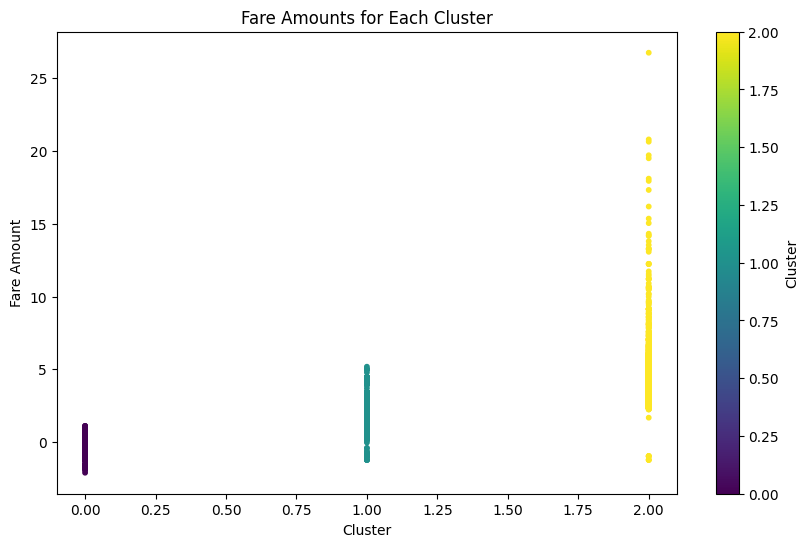

cluster_label
0   -0.349470
1    1.118673
2    3.949436
Name: fare_amount, dtype: float64
cluster_label
0   -0.364448
1    1.046422
2    4.066231
Name: trip_distance, dtype: float64


<ipython-input-51-ee7db6354276>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['optimal'] = 0  # Initialize 'optimal' column with zeros


Accuracy 0.9921498155679561
Precision: 0.9845619691239382
Recall: 1.0
F1 Score: 0.9922209378612266
Accuracy 0.8225669157287431
Precision: 0.889553146215422
Recall: 0.7371116708648194
F1 Score: 0.8061894485513567


In [ ]:
df_wednesday = df[df['weekday'] == 'Wednesday']
train_for_day(df_wednesday)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-78-d07ee53a75ad>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster_label'] = kmeans.fit_predict(features)


Silhouette Score: 0.6751771642348838
Davies-Bouldin Index: 0.5370076378324375
Calinski-Harabasz Index: 535584.6324839166
cluster_label
1    201535
0     40598
2      9039
Name: count, dtype: int64


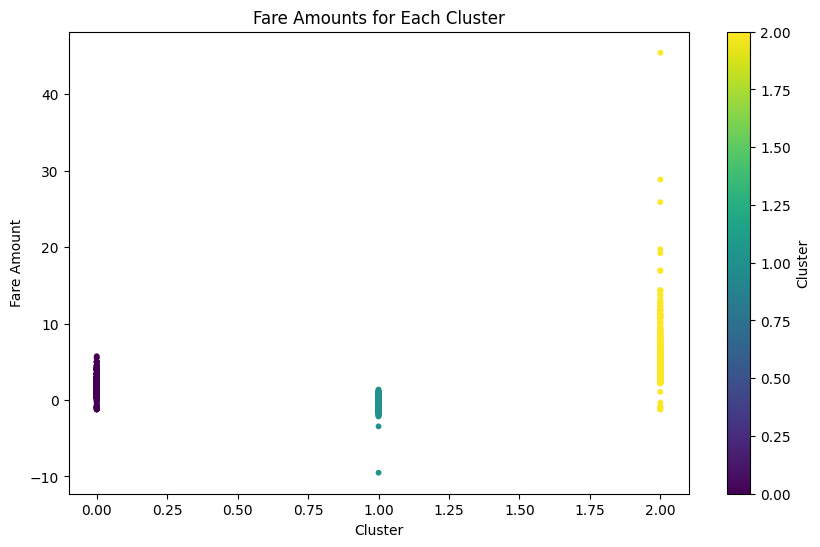

cluster_label
0    1.088448
1   -0.343305
2    3.860816
Name: fare_amount, dtype: float64
cluster_label
0    1.003405
1   -0.356510
2    3.951113
Name: trip_distance, dtype: float64


<ipython-input-80-ee7db6354276>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['optimal'] = 0  # Initialize 'optimal' column with zeros


Accuracy 0.9912527773877274
Precision: 0.9827827274500878
Recall: 1.0
F1 Score: 0.9913166115926105
Accuracy 0.8013496658874838
Precision: 0.8928825853247847
Recall: 0.6842296812188787
F1 Score: 0.774753680740269


In [ ]:
df_thursday = df[df['weekday'] == 'Thursday']
train_for_day(df_thursday)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-78-d07ee53a75ad>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster_label'] = kmeans.fit_predict(features)


Silhouette Score: 0.6856282397199854
Davies-Bouldin Index: 0.5264952194563098
Calinski-Harabasz Index: 521315.05901014654
cluster_label
0    204402
2     36995
1      8270
Name: count, dtype: int64


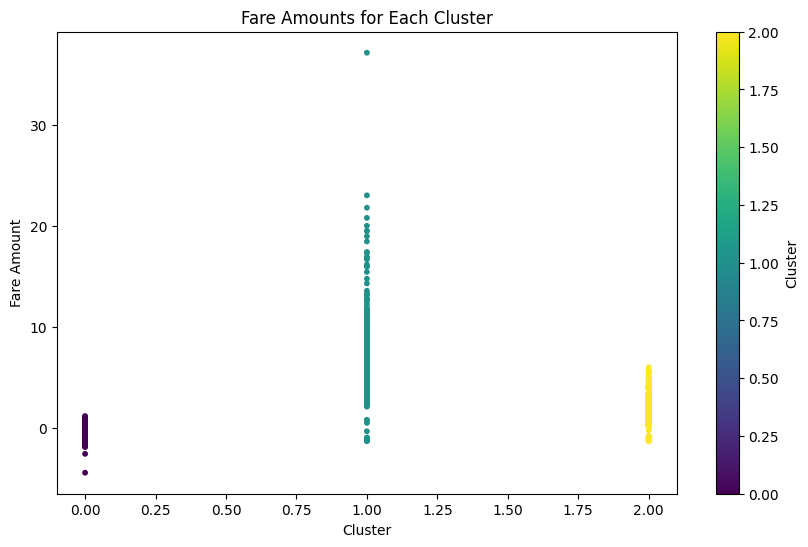

cluster_label
0   -0.337576
1    4.008816
2    1.140799
Name: fare_amount, dtype: float64
cluster_label
0   -0.357782
1    4.118807
2    1.038019
Name: trip_distance, dtype: float64


<ipython-input-80-ee7db6354276>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['optimal'] = 0  # Initialize 'optimal' column with zeros


Accuracy 0.9927837016048185
Precision: 0.9857588986445611
Recall: 1.0
F1 Score: 0.9928283834632897
Accuracy 0.806700966867994
Precision: 0.8891322200930741
Recall: 0.7003483164703931
F1 Score: 0.7835292589465479


In [ ]:
df_friday = df[df['weekday'] == 'Friday']
train_for_day(df_friday)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-78-d07ee53a75ad>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster_label'] = kmeans.fit_predict(features)


Silhouette Score: 0.6660611534966533
Davies-Bouldin Index: 0.5257117901695824
Calinski-Harabasz Index: 563307.1763612069
cluster_label
1    225292
0     49663
2      8061
Name: count, dtype: int64


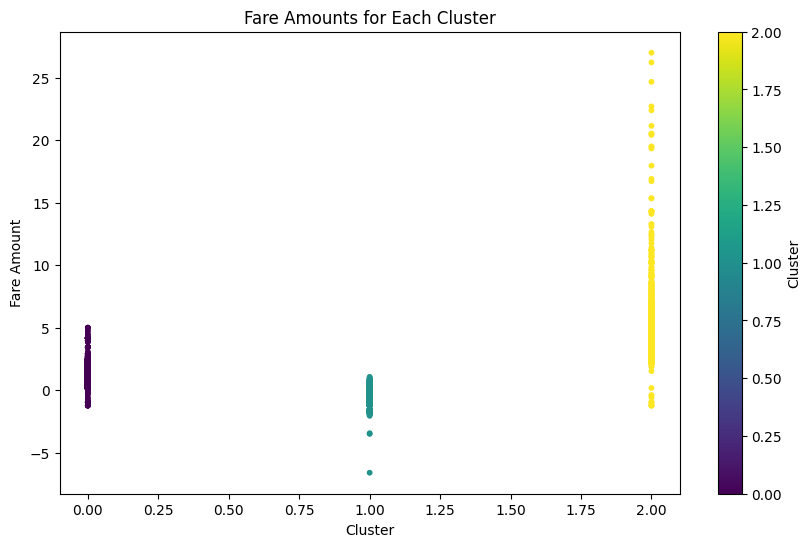

cluster_label
0    0.852406
1   -0.395815
2    3.858846
Name: fare_amount, dtype: float64
cluster_label
0    0.806352
1   -0.370388
2    4.052440
Name: trip_distance, dtype: float64


<ipython-input-80-ee7db6354276>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['optimal'] = 0  # Initialize 'optimal' column with zeros


Accuracy 0.9944427472031889
Precision: 0.9890314985499756
Recall: 1.0
F1 Score: 0.994485506409516
Accuracy 0.8012991169496211
Precision: 0.9022077746173642
Recall: 0.6768326317317462
F1 Score: 0.7734363984706106


In [ ]:
df_saturday = df[df['weekday'] == 'Saturday']
train_for_day(df_saturday)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-78-d07ee53a75ad>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster_label'] = kmeans.fit_predict(features)


Silhouette Score: 0.6979102545219655
Davies-Bouldin Index: 0.4989954743549272
Calinski-Harabasz Index: 419507.15604910953
cluster_label
0    137084
2     24731
1      6203
Name: count, dtype: int64


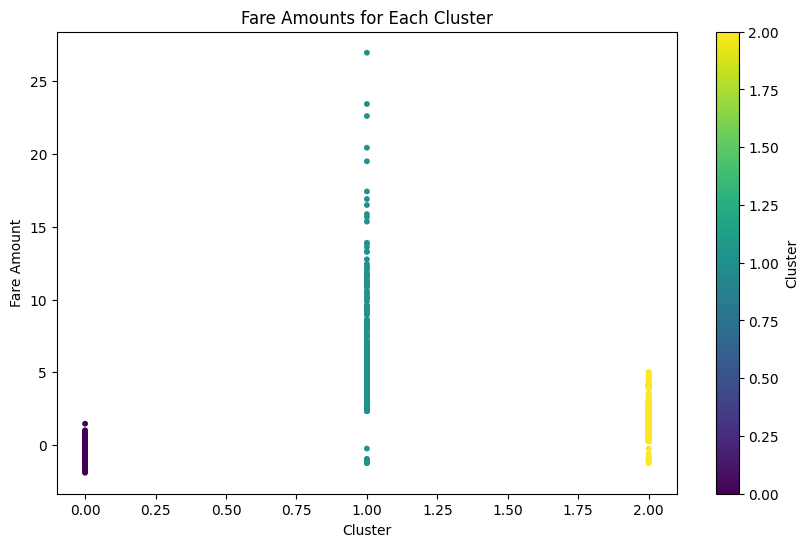

cluster_label
0   -0.375883
1    3.994120
2    1.128794
Name: fare_amount, dtype: float64
cluster_label
0   -0.322213
1    4.224055
2    1.176418
Name: trip_distance, dtype: float64


<ipython-input-80-ee7db6354276>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['optimal'] = 0  # Initialize 'optimal' column with zeros


Accuracy 0.9920403421169723
Precision: 0.9843228900411403
Recall: 1.0
F1 Score: 0.9920995166474471
Accuracy 0.820314431205814
Precision: 0.9058963668850506
Recall: 0.7147026091257573
F1 Score: 0.7990212342402123


In [ ]:
df_sunday = df[df['weekday'] == 'Sunday']
train_for_day(df_sunday)

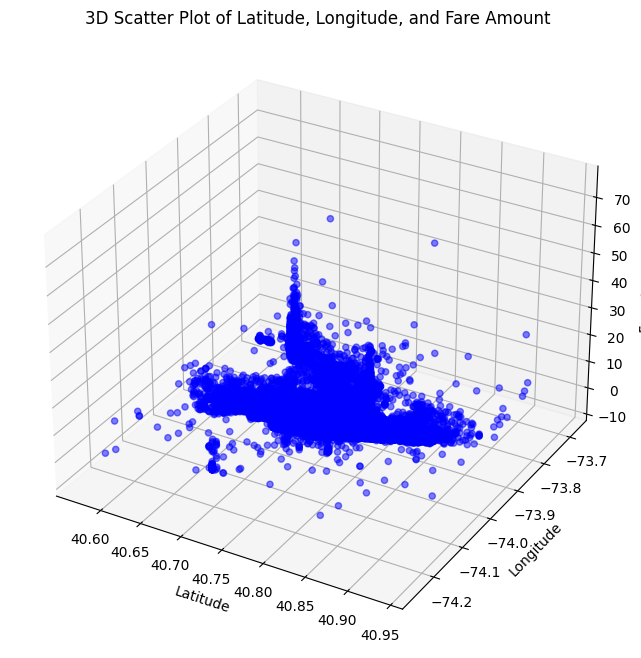

In [ ]:
plot_lat_long_fare( )

# **Trial & Error Code**

In [ ]:
df_monday = df[df['weekday'] == 'Monday']
df_monday_clustered = applyKMeans(df_monday)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-78-d07ee53a75ad>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster_label'] = kmeans.fit_predict(features)


In [ ]:
cluster_counts = df_monday_clustered['cluster_label'].value_counts()
print(cluster_counts)

cluster_label
0    119972
2     18391
1      5390
Name: count, dtype: int64


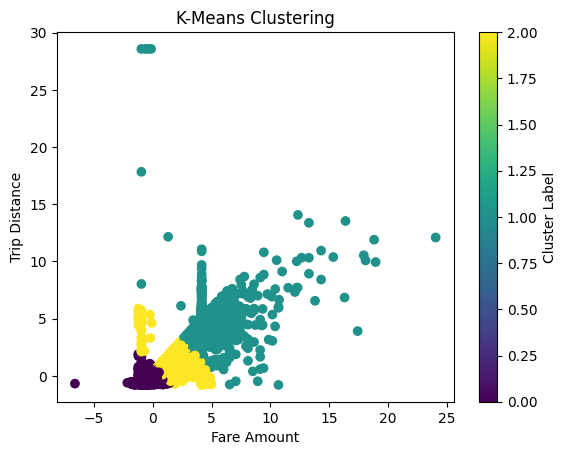

In [ ]:
import matplotlib.pyplot as plt

def plotClusters(df):
    # Extract features and cluster labels
    features = df[['fare_amount', 'trip_distance']]
    cluster_labels = df['cluster_label']

    # Plot the clusters
    plt.scatter(features['fare_amount'], features['trip_distance'], c=cluster_labels, cmap='viridis')
    plt.xlabel('Fare Amount')
    plt.ylabel('Trip Distance')
    plt.title('K-Means Clustering')
    plt.colorbar(label='Cluster Label')
    plt.show()

# Call the function after applying k-means
# df = applyKMeans(df)
plotClusters(df_monday_clustered)


In [ ]:
df_monday_clustered = find_optimal_cluster(df_monday_clustered)

cluster_label
0   -0.358983
1    4.106471
2    1.286873
Name: fare_amount, dtype: float64
cluster_label
0   -0.344454
1    4.290865
2    1.287683
Name: trip_distance, dtype: float64


<ipython-input-80-ee7db6354276>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['optimal'] = 0  # Initialize 'optimal' column with zeros


In [ ]:
df_monday_clustered.head()

,tpep_pickup_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,fare_amount,weekday,cluster_label,is_optimal,optimal,pickup_grid
98,2015-01-26 12:41:08,2,-0.527749,-73.966637,40.804657,-0.495970,Monday,0,0,0,53
99,2015-01-26 12:41:09,1,0.435131,-73.966644,40.804417,0.369316,Monday,0,1,0,53
100,2015-01-26 12:41:09,1,-0.673640,-73.982811,40.745255,-0.750466,Monday,0,0,0,41
101,2015-01-26 12:41:09,1,-0.586105,-73.991493,40.738937,-0.699567,Monday,0,0,0,41
102,2015-01-26 12:41:10,1,-0.498571,-73.982391,40.757408,0.267518,Monday,0,0,0,41


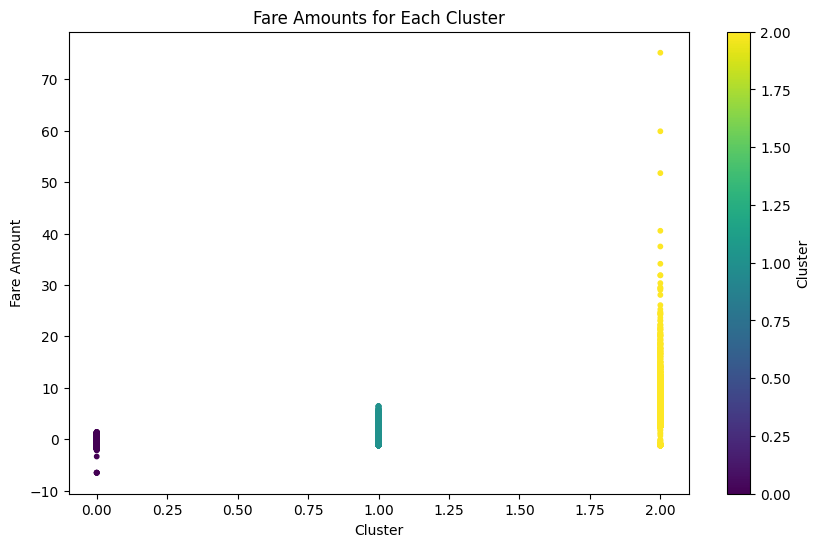

In [ ]:
plot_cluster_fare(df_monday_clustered)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import folium


def applyGrid(df):
    # Define the boundaries of the geographic area of interest using pickup locations
    min_lat = df['pickup_latitude'].min()
    max_lat = df['pickup_latitude'].max()
    min_lon = df['pickup_longitude'].min()
    max_lon = df['pickup_longitude'].max()

    # Define the size of the grid cells (in degrees)
    grid_size = 0.05  # Decreased grid size for more grids

    # Calculate the number of grid cells in latitude and longitude directions
    num_lat_cells = int(np.ceil((max_lat - min_lat) / grid_size))
    num_lon_cells = int(np.ceil((max_lon - min_lon) / grid_size))

    def assign_grid_id(latitude, longitude):
        lat_index = int(np.floor((latitude - min_lat) / grid_size))
        lon_index = int(np.floor((longitude - min_lon) / grid_size))
        return lat_index * num_lon_cells + lon_index

    # Apply the function to add a column for pickup grid cell ID in the DataFrame
    df['pickup_grid'] = df.apply(lambda row: assign_grid_id(row['pickup_latitude'], row['pickup_longitude']), axis=1)

    return df


In [ ]:
df_monday_clustered = applyGrid(df_monday_clustered)

<ipython-input-56-4f625c9f8962>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pickup_grid'] = df.apply(lambda row: assign_grid_id(row['pickup_latitude'], row['pickup_longitude']), axis=1)


# **Classification**

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Define your features (X) and target variable (y)
X = df_monday_clustered[['pickup_latitude', 'pickup_longitude']]  # Add additional relevant features as needed
y = df_monday_clustered['optimal']  # Your binary labels

# Initialize RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Resample the dataset
X_ros, y_ros = ros.fit_resample(X, y)

# Print the original and resampled dataset shapes
print('Original dataset shape:', Counter(y))
print('Resampled dataset shape:', Counter(y_ros))

Original dataset shape: Counter({0: 1249976, 1: 48872})
Resampled dataset shape: Counter({0: 1249976, 1: 1249976})


In [ ]:
X = X_ros#df_monday_clustered[['pickup_latitude', 'pickup_longitude']]  # Add additional relevant features as needed
y = y_ros#df_monday_clustered['optimal']  # Your binary labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
# Train a RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=20, class_weight='balanced', random_state=42)
classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=20, random_state=42)

In [ ]:
# Predict and evaluate the model
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Accuracy", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy 0.9904046157686227
Precision: 0.981230409121858
Recall: 0.9999520368357102
F1 Score: 0.9905027658695029


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Calculate class weights
class_weights = dict(zip([1, 0], ((len(y_train) - y_train.sum()) / len(y_train), y_train.sum() / len(y_train))))

# Initialize RandomForestClassifier with class weights
rf = RandomForestClassifier(n_estimators=10, class_weight=class_weights, random_state=42)

# Fit the model
rf.fit(X_train, y_train)

# Make predictions
predictions = rf.predict(X_test)

# Evaluate the model
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    312512
           1       0.70      0.50      0.58     12200

    accuracy                           0.97    324712
   macro avg       0.84      0.74      0.78    324712
weighted avg       0.97      0.97      0.97    324712



In [ ]:
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
print("Accuracy", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy 0.9729883712335855
Precision: 0.6975458002073972
Recall: 0.4962295081967213
F1 Score: 0.5799128310742852


In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier

# Initialize BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
brf.fit(X_train, y_train)

# Make predictions
predictions = brf.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.para

In [ ]:
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
print("Accuracy", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy 0.8685481288033704
Precision: 0.18319753907549052
Recall: 0.7224590163934427
F1 Score: 0.2922801432550736


In [ ]:
from sklearn.utils import class_weight
import xgboost as xgb

classes_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)

# Initialize XGBoost classifier with class weights
xgb_classifier = xgb.XGBClassifier(scale_pos_weight=sum(y_train == 0) / sum(y_train == 1))

# Fit the classifier to the training data
xgb_classifier.fit(X_train, y_train, sample_weight=classes_weights)
predictions = xgb_classifier.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
print("Accuracy", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy 0.8162476719553016
Precision: 0.9251479124684733
Recall: 0.6884888405704419
F1 Score: 0.7894639390334


In [ ]:
sample_df = df[df['cluster_label']==1]

In [ ]:
sample_df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,...,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,cluster_label,is_optimal
5,1,2015-01-10 20:33:39,2015-01-10 20:53:52,1,9.00,-73.874374,40.774048,1,N,-73.986977,...,1,27.0,0.5,0.5,6.70,5.33,0.3,40.33,1,1
13,1,2015-01-10 20:33:41,2015-01-10 21:03:04,1,3.10,-73.973946,40.760448,1,N,-73.997345,...,1,19.0,0.5,0.5,3.00,0.00,0.3,23.30,1,0
17,2,2015-01-15 19:05:40,2015-01-15 19:28:18,5,8.33,-73.863060,40.769581,1,N,-73.952713,...,1,26.0,1.0,0.5,8.08,5.33,0.3,41.21,1,1
19,2,2015-01-15 19:05:41,2015-01-15 19:20:22,2,7.13,-73.874458,40.774010,1,N,-73.952377,...,1,21.5,1.0,0.5,4.50,0.00,0.3,27.80,1,0
20,2,2015-01-15 19:05:41,2015-01-15 19:31:00,1,3.60,-73.976601,40.751896,1,N,-73.998924,...,2,17.5,1.0,0.5,0.00,0.00,0.3,19.30,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749973,2,2015-01-17 23:38:19,2015-01-17 23:55:17,3,4.86,-73.979759,40.760971,1,N,-73.950340,...,1,16.5,0.5,0.5,3.40,0.00,0.3,21.20,1,0
749977,2,2015-01-17 23:38:20,2015-01-17 23:57:48,2,4.07,-73.992989,40.763088,1,N,-74.004959,...,2,16.5,0.5,0.5,0.00,0.00,0.3,17.80,1,0
749980,2,2015-01-17 23:38:21,2015-01-18 00:04:03,1,4.23,-73.997002,40.737316,1,N,-73.963287,...,1,19.5,0.5,0.5,2.50,0.00,0.3,23.30,1,0
749986,1,2015-01-28 10:41:10,2015-01-28 11:04:15,1,11.20,-73.971916,40.753799,1,N,-73.865486,...,1,33.0,0.0,0.5,7.80,5.33,0.3,46.93,1,1


In [ ]:
X = df[['fare_amount','trip_distance','pickup_latitude','pickup_longitude']]  # Add additional relevant features as needed
y = df['optimal']  # Your binary labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

KeyError: 'optimal'

In [ ]:
# Train a RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Predict and evaluate the model
y_pred = classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9999520679265954


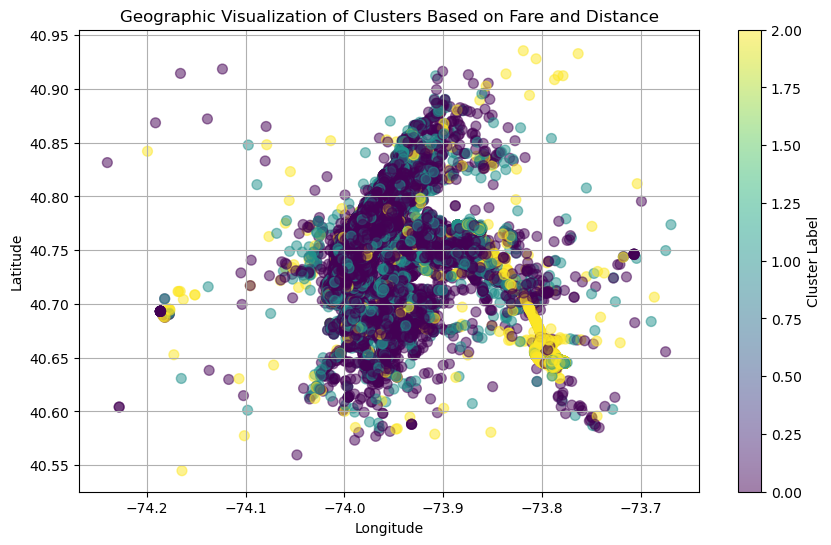

In [ ]:
# Visualizing the clusters based on pickup locations
plt.figure(figsize=(10, 6))
#df_optimal = df[df['is_optimal'] == 1]
# Scatter plot for pickups colored by cluster labels derived from fare and distance
plt.scatter(df['pickup_longitude'], df['pickup_latitude'], c=df['cluster_label'], cmap='viridis', s=50, alpha=0.5)
#plt.scatter(df_optimal['pickup_longitude'], df_optimal['pickup_latitude'], c=df_optimal['cluster_label'], cmap='viridis', s=50, alpha=0.5)

# Compute geographical centers for the clusters if you want to plot them
if 'pickup_longitude' in features.columns and 'pickup_latitude' in features.columns:
    # Calculate cluster centers in geographic terms, which requires re-fitting KMeans or a similar calculation
    # This is an optional step and depends on your specific analysis needs
    geoclusters = KMeans(n_clusters=k, random_state=42).fit(df[['pickup_longitude', 'pickup_latitude']])
    geo_centers = geoclusters.cluster_centers_
    plt.scatter(geo_centers[:, 0], geo_centers[:, 1], c='red', s=200, alpha=0.9, marker='o')

# If not plotting actual geographic centers, you can skip plotting centers or plot the mean location per cluster as above

# Beautify the plot
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Visualization of Clusters Based on Fare and Distance')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()


In [ ]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,...,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,cluster_label,is_optimal
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,...,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05,0,0
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,...,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80,0,1
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,...,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80,0,1
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,...,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0,0
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,...,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30,0,1


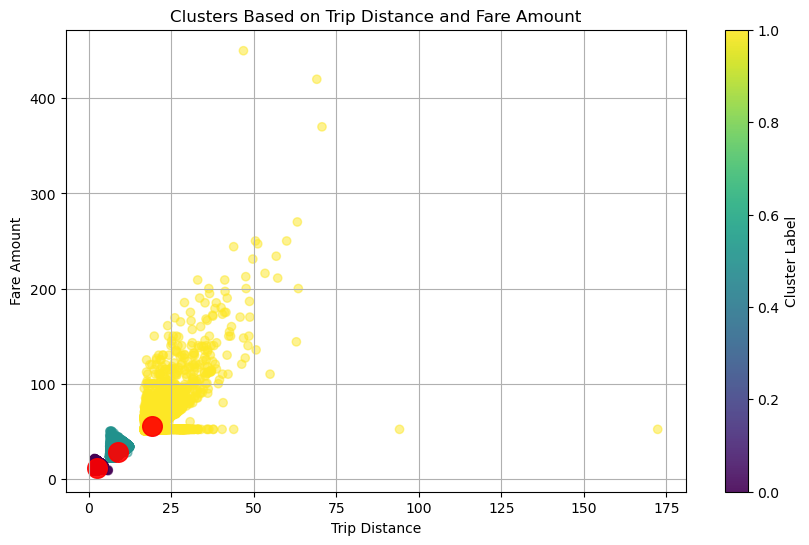

In [ ]:
# Visualizing the clusters based on trip distance and fare amount
plt.figure(figsize=(10, 6))

# Scatter plot for clusters
plt.scatter(df['trip_distance'], df['fare_amount'], c=df['cluster_label'], cmap='viridis', alpha=0.5)

# Marking cluster centers if desired. Note: These centers are in the scaled space.
# To plot them accurately, you'll need to transform them back or calculate mean fare and distance in the original space.
# Here's a way to plot mean fare and distance for each cluster as "centers":
for cluster in df['cluster_label'].unique():
    mean_fare = df[df['cluster_label'] == cluster]['fare_amount'].mean()
    mean_distance = df[df['cluster_label'] == cluster]['trip_distance'].mean()
    plt.scatter(mean_distance, mean_fare, c='red', s=200, alpha=0.9, marker='o')

plt.xlabel('Trip Distance')
plt.ylabel('Fare Amount')
plt.title('Clusters Based on Trip Distance and Fare Amount')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()